In [ ]:
import pandas as pd
import numpy as np
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing as preproc
from scipy import stats
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score, KFold,train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import resample
from imblearn.under_sampling import ClusterCentroids
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import f1_score
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

In [ ]:
# Check for GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cpu


In [ ]:
df=pd.read_csv("diabetic_data_cleaned_pca_som_diag_grouped_ae_dbscan.csv")

In [ ]:
df.head()

,Unnamed: 0,encounter_id,patient_nbr,race,gender,age,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,ae_4,ae_5,ae_6,ae_7,ae_8,ae_9,ae_10,ae_11,ae_12,ae_13
0,0,149190,55629189,Caucasian,Female,[10-20),1,1,7,3,...,8.584562,20.436142,5.291698,8.157053,17.783960,23.949799,11.668662,8.264934,22.667690,27.363850
1,1,64410,86047875,AfricanAmerican,Female,[20-30),1,1,7,2,...,15.110230,15.245245,33.812020,2.966186,29.897364,28.222050,23.203943,12.367907,29.435223,36.155518
2,2,500364,82442376,Caucasian,Male,[30-40),1,1,7,2,...,1.598465,25.428694,8.711449,21.261776,11.921114,30.430517,22.689114,7.689127,13.135617,25.826536
3,3,16680,42519267,Caucasian,Male,[40-50),1,1,7,1,...,13.074265,8.245643,12.659610,19.848545,6.032684,29.801752,10.818433,3.274082,20.075940,10.891075
4,4,35754,82637451,Caucasian,Male,[50-60),2,1,2,3,...,31.112360,17.769810,11.906863,35.779766,28.849283,11.464336,28.415997,17.790482,19.180480,26.632393


In [ ]:
df.columns

Index(['Unnamed: 0', 'encounter_id', 'patient_nbr', 'race', 'gender', 'age',
       'admission_type_id', 'discharge_disposition_id', 'admission_source_id',
       'time_in_hospital', 'num_lab_procedures', 'num_procedures',
       'num_medications', 'number_outpatient', 'number_emergency',
       'number_inpatient', 'diag_1', 'diag_2', 'diag_3', 'number_diagnoses',
       'metformin', 'repaglinide', 'glimepiride', 'glipizide', 'glyburide',
       'pioglitazone', 'rosiglitazone', 'insulin', 'glyburide-metformin',
       'change', 'diabetesMed', 'readmitted', 'PC1', 'PC2', 'PC3',
       'som_jaccard_0', 'som_jaccard_1', 'som_euc_0', 'som_euc_1',
       'diag_1_group', 'diag_2_group', 'diag_3_group', 'ae_0', 'ae_1', 'ae_2',
       'ae_3', 'ae_4', 'ae_5', 'ae_6', 'ae_7', 'ae_8', 'ae_9', 'ae_10',
       'ae_11', 'ae_12', 'ae_13'],
      dtype='object')

In [ ]:
print(df[df['readmitted']=='NO'].shape)
print(df[df['readmitted']=='>30'].shape)
print(df[df['readmitted']=='<30'].shape)

(53212, 56)
(34744, 56)
(11110, 56)


In [ ]:
df_3_levels=df.copy()

In [ ]:
df_2_levels=df.copy()
df_2_levels['readmitted'] = df_2_levels['readmitted'].replace('NO', '>30')

In [ ]:
print(df['readmitted'].unique())
print(df_2_levels['readmitted'].unique())
print(df_3_levels['readmitted'].unique())

['>30' 'NO' '<30']
['>30' '<30']
['>30' 'NO' '<30']


In [ ]:
print(df_2_levels[df_2_levels['readmitted']=='NO'].shape)
print(df_2_levels[df_2_levels['readmitted']=='>30'].shape)
print(df_2_levels[df_2_levels['readmitted']=='<30'].shape)

(0, 56)
(87956, 56)
(11110, 56)


In [ ]:
#df=df_downsampled
df=df_2_levels.copy()

In [ ]:
print(df[df['readmitted']=='NO'].shape)
print(df[df['readmitted']=='>30'].shape)
print(df[df['readmitted']=='<30'].shape)

(0, 56)
(87956, 56)
(11110, 56)


In [ ]:
y=df['readmitted']

In [ ]:
# Assuming 'y' contains your target variable
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

In [ ]:
y_encoded

array([1, 1, 1, ..., 1, 1, 1])

In [ ]:
column1=[
  'PC1','PC2', 'PC3',
  'ae_0', 'ae_1', 'ae_2', 'ae_3', 'ae_4',
  'ae_5', 'ae_6', 'ae_7', 'ae_8', 'ae_9',
  'ae_10', 'ae_11', 'ae_12', 'ae_13'
]
# column1=[
#   'PC1','PC2', 'PC3'
# ]
df[column1].head()

,PC1,PC2,PC3,ae_0,ae_1,ae_2,ae_3,ae_4,ae_5,ae_6,ae_7,ae_8,ae_9,ae_10,ae_11,ae_12,ae_13
0,-0.214843,0.070744,-0.194516,21.509342,19.395063,13.789462,18.633125,8.584562,20.436142,5.291698,8.157053,17.783960,23.949799,11.668662,8.264934,22.667690,27.363850
1,0.417941,-0.522845,0.160733,35.920300,9.260715,18.687860,9.814375,15.110230,15.245245,33.812020,2.966186,29.897364,28.222050,23.203943,12.367907,29.435223,36.155518
2,-0.129162,-0.131116,-0.050765,25.516636,20.602080,21.286129,11.283273,1.598465,25.428694,8.711449,21.261776,11.921114,30.430517,22.689114,7.689127,13.135617,25.826536
3,-0.333245,-0.143083,-0.009183,15.020832,18.029790,14.233169,6.268053,13.074265,8.245643,12.659610,19.848545,6.032684,29.801752,10.818433,3.274082,20.075940,10.891075
4,0.640729,-0.446888,-0.059434,17.637230,34.109043,10.788097,20.966002,31.112360,17.769810,11.906863,35.779766,28.849283,11.464336,28.415997,17.790482,19.180480,26.632393


In [ ]:
X=df[column1]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.05, random_state=42,stratify=y_encoded)

In [ ]:
# Normalize the features
scaler = preproc.MinMaxScaler()
X_train_normalized = scaler.fit_transform(X_train)

In [ ]:
X_test_normalized=scaler.transform(X_test)

# Deep Learning

In [ ]:
# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train_normalized, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_normalized, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

In [ ]:
print(X_train_tensor.shape)
print(X_test_tensor.shape)
print(y_train_tensor.shape)
print(y_test_tensor.shape)

torch.Size([94112, 17])
torch.Size([4954, 17])
torch.Size([94112])
torch.Size([4954])


In [ ]:
# # Assuming df contains your data
# X = df.drop('target_variable_column_name', axis=1)  # Features (input)
# y = df['readmitted']  # Target variable (output)

# # Convert pandas DataFrame to PyTorch tensors
# X_tensor = torch.tensor(X.values, dtype=torch.float32)
# y_tensor = torch.tensor(y.values, dtype=torch.float32)

# # Printing shapes to verify
# print("X_tensor shape:", X_tensor.shape)
# print("y_tensor shape:", y_tensor.shape)
class_weights = compute_class_weight('balanced', classes=[0, 1], y=y_encoded)
print(class_weights)
class_weights = torch.tensor(class_weights, dtype=torch.float32)

# Define loss function with class weights


[4.45841584 0.56315658]


In [ ]:
# Define your deep neural network architecture
class DeepNeuralNetwork(nn.Module):
    def __init__(self, input_size):
        super(DeepNeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, 12)  # Input layer to first hidden layer
        self.fc2 = nn.Linear(12, 8)
        self.fc3 = nn.Linear(8, 4)  # First hidden layer to second hidden layer
        self.fc4 = nn.Linear(4, 1)   # Second hidden layer to output layer
        #self.sigmoid = nn.Sigmoid()   # Sigmoid activation function

    def forward(self, x):
        x = torch.relu(self.fc1(x))  # Apply ReLU activation to first hidden layer
        x = torch.relu(self.fc2(x))  # Apply ReLU activation to second hidden layer
        x = torch.relu(self.fc3(x))  # Apply ReLU activation to second hidden layer
        x = self.fc4(x)              # Output layer
        #x = self.sigmoid(x)

        return x

# Instantiate your deep neural network
input_size = X_train_tensor.shape[1]  # Number of features
model = DeepNeuralNetwork(input_size)

# Calculate class weights
class_weights = compute_class_weight('balanced', classes=[0, 1], y=y_train)
class_weights= 0.224#class_weights[1]/class_weights[0]
class_weights = torch.tensor(class_weights, dtype=torch.float32)
#print(class_weights.shape)

# Define loss function with class weights
criterion = nn.BCEWithLogitsLoss(pos_weight=class_weights)

# Define loss function and optimizer
#criterion = nn.BCELoss(weight=class_weights)  # Binary Cross-Entropy loss for binary classification
optimizer = optim.Adam(model.parameters(), lr=0.001,weight_decay=1e-5)  # Adam optimizer

# Training loop
num_epochs = 7
for epoch in range(num_epochs):
    running_loss = 0.0
    for inputs, labels in zip(X_train_tensor, y_train_tensor):
        optimizer.zero_grad()  # Zero the gradients
        # outputs = model(inputs.unsqueeze(0))  # Forward pass
        # outputs = outputs.squeeze()  # Remove any singleton dimensions
        # print(outputs.shape)
        # print(labels.shape)
        # loss = criterion(outputs, labels)  # Calculate the loss
        outputs = model(inputs.unsqueeze(0))  # Forward pass
        #outputs = outputs.item()  # Remove any singleton dimensions
        outputs = outputs.squeeze()
        # print(outputs.shape)
        # print(labels.shape)
        loss = criterion(outputs, labels)
        #print(labels.shape)
        loss.backward()  # Backward pass
        optimizer.step()  # Update weights
        running_loss += loss.item()
    epoch_loss = running_loss / len(X_train_tensor)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}")

# Evaluation on the testing set
model.eval()  # Set the model to evaluation mode
predictions = []
raw_predictions=[]

with torch.no_grad():  # Disable gradient tracking
    #test_loss = 0.0
    for inputs, labels in zip(X_test_tensor, y_test_tensor):
        outputs = model(inputs.unsqueeze(0))  # Forward pass
        #outputs = outputs.squeeze()  # Remove any singleton dimensions
        #test_loss += criterion(outputs, labels.unsqueeze(0)).item()
        raw_predictions.append(outputs.item())
        predicted_label = 1 if outputs.item() > 0.5 else 0  # Convert probability to binary label
        predictions.append(predicted_label)
    # avg_test_loss = test_loss / len(X_test_tensor)
    # print(f"Average Test Loss: {avg_test_loss:.4f}")
# Calculate F1 score
# Calculate F1 score for each label
f1_per_label = f1_score(y_test_tensor, predictions, average=None)

# Print F1 score for each label
for label, f1 in enumerate(f1_per_label):
    print(f"F1 Score for Label {label}: {f1:.4f}")

# Additionally, you can print a classification report which includes precision, recall, and F1-score
print(classification_report(y_test_tensor, predictions))

Epoch 1/7, Loss: 0.2015
Epoch 2/7, Loss: 0.2007
Epoch 3/7, Loss: 0.2006
Epoch 4/7, Loss: 0.2004
Epoch 5/7, Loss: 0.2003
Epoch 6/7, Loss: 0.2002
Epoch 7/7, Loss: 0.2001
F1 Score for Label 0: 0.2359
F1 Score for Label 1: 0.7501
              precision    recall  f1-score   support

         0.0       0.15      0.52      0.24       556
         1.0       0.91      0.64      0.75      4398

    accuracy                           0.62      4954
   macro avg       0.53      0.58      0.49      4954
weighted avg       0.83      0.62      0.69      4954



In [ ]:
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
non_trainable_params = sum(p.numel() for p in model.parameters() if not p.requires_grad)

print("Trainable parameters in the model:", trainable_params)
print("Non-trainable parameters in the model:", non_trainable_params)

Trainable parameters in the model: 361
Non-trainable parameters in the model: 0


In [ ]:
print(model)

DeepNeuralNetwork(
  (fc1): Linear(in_features=17, out_features=12, bias=True)
  (fc2): Linear(in_features=12, out_features=8, bias=True)
  (fc3): Linear(in_features=8, out_features=4, bias=True)
  (fc4): Linear(in_features=4, out_features=1, bias=True)
)


In [ ]:
for i in predictions:
  if i==0:
    print('Heyy')

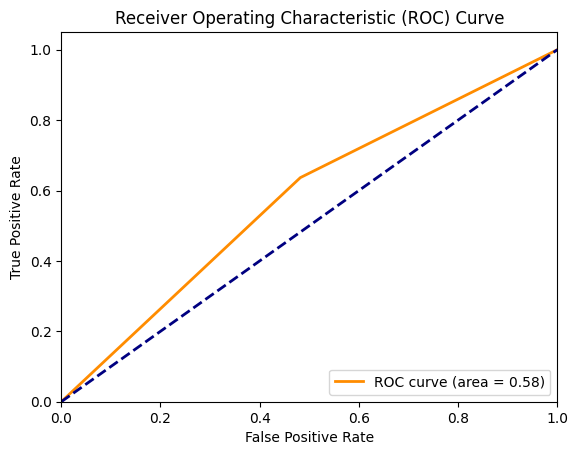

In [ ]:
# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test_tensor, predictions)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

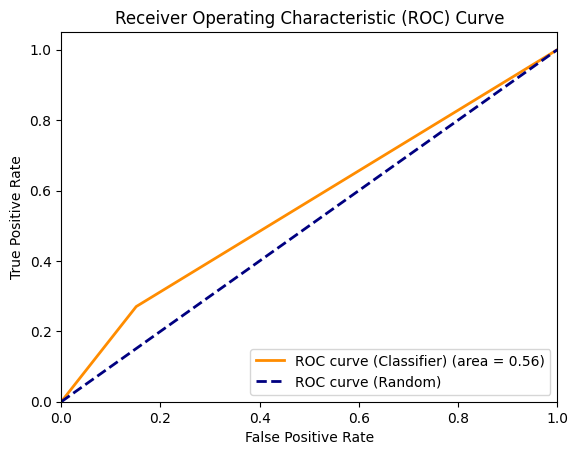

In [ ]:
# Calculate ROC curve for the classifier
fpr, tpr, thresholds = roc_curve(y_test_tensor, predictions)
roc_auc = auc(fpr, tpr)

# Calculate ROC curve for a random classifier
random_probs = [0 for _ in range(len(y_test_tensor))]
random_fpr, random_tpr, _ = roc_curve(y_test_tensor, random_probs)
random_roc_auc = auc(random_fpr, random_tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (Classifier) (area = %0.2f)' % roc_auc)
plt.plot(random_fpr, random_tpr, color='navy', lw=2, linestyle='--', label='ROC curve (Random)')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()